In [1]:
# Let's import some libraries first
import torch
from torch import optim
from torch import nn
import torch.nn.functional as F

import pandas as pd

import numpy as np
from tqdm.auto import tqdm

# 0. Introduction to Pytorch 
There are different architectures for Neural Networks (NNs). Those architectures are defined by blocks called layers. In this notebook we will learn how to use common layers to build a neural networks from scratch. We will also learn how to train the neural network using the `Pytorch` library and evaluate its performance.

In Pytorch, we can organise those layers using containers. The most common one that we will use is the `torch.nn.Sequential` layer.

In a sequential container, the modules (including activation functions and layers) will be added to it in the order they are passed. Alternatively, an ordered dictionary of modules can also be passed in.

To make it easier to understand, here is a small example:

Source: [Pytorch Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)

```python

# Import OrderedDict, which is in the standard collection library for python
from collections import OrderedDict

# Import nn to use basic building blocks
import torch.nn as nn

# Example of using Sequential
model = nn.Sequential(
          nn.Conv2d(1,20,5), # This is a Convolutional Layer 
          nn.ReLU(),         # This is an activation function
          nn.Conv2d(20,64,5),
          nn.ReLU()
        )

# Example of using Sequential with OrderedDict
# This is equivalent to the first model
model = nn.Sequential(OrderedDict([
          ('conv1', nn.Conv2d(1,20,5)),
          ('relu1', nn.ReLU()),
          ('conv2', nn.Conv2d(20,64,5)),
          ('relu2', nn.ReLU())
        ]))
```

As you can notice from the examples, `nn` contains the basic building blocks for Neural Networks as well as activiation functions, loss functions and some other useful functions.

## 1. Layers in Pytorch


### 1.2 Linear (or Dense) Layer

Fully connected neural networks (FCNNs) are a type of artificial neural network where  all the neurones, in one layer are connected to the neurones in the next layer. This type of layer is defined in Pytorch by [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear).

### 1.3 Convolutional Neural Networks

The convolutional layer is the core building block of a CNN. The layer's parameters consist of a set of learnable filters (or kernels). During the forward pass, each filter is convolved across the width and height of the input volume, computing the dot product between the entries of the filter and the input and producing a 2-dimensional activation map of that filter. As a result, the network learns filters that activate when it detects some specific type of feature at some spatial position in the input.

<h4>Architecture in a CNN:</h4>

A convolutional neural network consists of an input and an output layer, as well as multiple hidden layers. The hidden layers of a CNN typically consist of a series of convolutional layers that convolve with a multiplication or other dot product. The activation function is commonly a RELU layer, and is subsequently followed by additional convolutions such as pooling layers, fully connected layers and normalization layers, referred to as hidden layers because their inputs and outputs are masked by the activation function and final convolution.

<h4> CNN Layer: </h4>

<div class="alert alert-info" style="font-size:100%">

**NOTE:** <br>
Use `nn.Conv2d` in Pytorch for 2d Convolutions.
</div>

A convolutional layer within a neural network should have the following attributes:
- Convolutional kernels defined by a width and height (hyper-parameters).
- The number of input channels and output channels (hyper-parameter).
- The depth of the Convolution filter (the input channels) must be equal to the number channels (depth) of the input feature map. <br>

In a CNNs, feature maps are extracted and the they are downsampled until the last layer where it usually have fully connected layer. Look at the examples in the image below:

[Source Image](https://en.wikipedia.org/wiki/Convolutional_neural_network#/media/File:Typical_cnn.png)
<img src='https://upload.wikimedia.org/wikipedia/commons/6/63/Typical_cnn.png' width=800 height=300>


In neural networks, each neuron receives input from some number of locations in the previous layer. In a fully connected layer, each neuron receives input from every element of the previous layer. In a convolutional layer, neurons receive input from only a restricted subarea of the previous layer.

<h4> Pooling Layers</h4>

<div class="alert alert-info" style="font-size:100%">

**NOTE:** <br>
Use `nn.maxpool2d` in Pytorch for 2d Max Pooling.
</div>

Another important concept of CNNs is pooling, which is a form of non-linear down-sampling. The example below, shows Max pooling with a 2x2 filter and stride = 2. In every sub-region, the max value obtained.

[Source Image](https://en.wikipedia.org/wiki/Convolutional_neural_network#/media/File:Max_pooling.png)
<img src='https://upload.wikimedia.org/wikipedia/commons/e/e9/Max_pooling.png' width=400 heigh=400/>

# CNN implementation in Pytorch

Data source: https://dataunderground.org/dataset/landmass-f3

Credits to researchers at Georgia Tech, Agile Geoscience
License CCbySA

In this notebook, we will be using the landmass dataset, which have been preprocessed already. In this dataset, we have images of 4 different types of landmass: ['Discontinuous', 'Faulted', 'Continuous', 'Salt'].

This is an example of [seismic data](https://en.wikipedia.org/wiki/Reflection_seismology) which is a way of using seismic to image the structure of the Earth, below the surface. These waves are similar to sounds waves in air. The lines represent changes in density below the surface.

We will train a CNN to learn how to classify images into those 4 groups.

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
# Let's import the Patches
from deep_ml_curriculum.data.landmass_f3 import LandmassF3Patches
from deep_ml_curriculum.config import project_dir

landmassf3_train = LandmassF3Patches(
    project_dir / "data/processed/landmass-f3", train=True
)
landmassf3_test = LandmassF3Patches(
    project_dir / "data/processed/landmass-f3", train=False
)
print(landmassf3_train)
print(landmassf3_test)

Dataset LandmassF3Patches
    Number of datapoints: 13250
    Root location: /home/wassname/notebooks/deep_ml_curriculum/data/processed/landmass-f3
    Split: Train
Dataset LandmassF3Patches
    Number of datapoints: 4417
    Root location: /home/wassname/notebooks/deep_ml_curriculum/data/processed/landmass-f3
    Split: Test


Class: Continuous


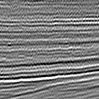

Class: Continuous


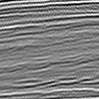

Class: Discontinuous


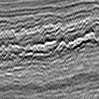

Class: Continuous


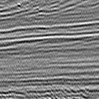

In [4]:
for i in range(4):
    x, y = landmassf3_train[i]
    print("Class:", landmassf3_train.classes[y])
    display(x)

In [5]:
# Let's have a look at the dataset
print(landmassf3_train.data.shape)
print(landmassf3_test.data.shape)

torch.Size([13250, 99, 99])
torch.Size([4417, 99, 99])


In [6]:
LandmassF3Patches

deep_ml_curriculum.data.landmass_f3.LandmassF3Patches

In this dataset, we have a total of 13250 gray-scale images of 99x99 pixels.

Let's display the first one:

Class: Continuous


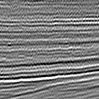

Class: Continuous


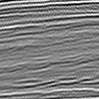

Class: Discontinuous


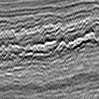

Class: Continuous


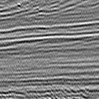

Class: Discontinuous


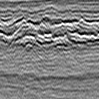

Class: Continuous


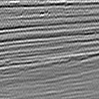

Class: Continuous


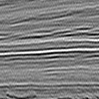

Class: Discontinuous


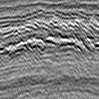

Class: Salt


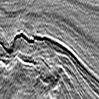

Class: Continuous


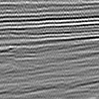

In [7]:
for i in range(10):
    x, y = landmassf3_train[i]
    print("Class:", landmassf3_train.classes[y])
    display(x)

In [8]:
# Note that this is an unbalanced dataset, so we expect an accuracy of at least 52%, this is out baseline
labels = pd.Series(landmassf3_train.train_labels).replace(dict(enumerate(landmassf3_train.classes)))
labels.value_counts() / len(landmassf3_train)

/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Continuous       0.529358
Discontinuous    0.291396
Salt             0.108453
Faulted          0.070792
dtype: float64

In [9]:
landmassf3_train.classes

['Discontinuous', 'Faulted', 'Continuous', 'Salt']

Source: [Neural Networks](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py)

Now let's implement our first NN from scratch using Pytorch. A typical training procedure for a neural network is as follows:

- Define the neural network that has some learnable parameters (or weights)
- Iterate over a dataset of inputs
- Process input through the network
- Compute the loss (how far is the output from being correct)
- Propagate gradients back into the network’s parameters
- Update the weights of the network, typically using a simple update rule: weight = weight - learning_rate * gradient

Steps:

1. Create a python class with `nn.Module`
2. Let's define two functions:
   - The first one `__init__` also called contructor. Here we wil define the blocks that we will use.
   - Define a `forward` function. In Pytorch, `forward` is a reserved name for a function that takes the input and returns and output. You can define the flow of the architecture here.
   
   
<h3> Define the network</h3>

In [10]:
help(nn.Conv2d)

Help on class Conv2d in module torch.nn.modules.conv:

class Conv2d(_ConvNd)
 |  Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
 |  
 |  Applies a 2D convolution over an input signal composed of several input
 |  planes.
 |  
 |  In the simplest case, the output value of the layer with input size
 |  :math:`(N, C_{\text{in}}, H, W)` and output :math:`(N, C_{\text{out}}, H_{\text{out}}, W_{\text{out}})`
 |  can be precisely described as:
 |  
 |  .. math::
 |      \text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
 |      \sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)
 |  
 |  
 |  where :math:`\star` is the valid 2D `cross-correlation`_ operator,
 |  :math:`N` is a batch size, :math:`C` denotes a number of channels,
 |  :math:`H` is a height of input planes in pixels, and :math:`W` is
 |  width in pixels.
 |  
 |  * :attr:`stride` controls the str

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 23 * 23, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [12]:
# Create an instance of your network
net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=8464, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=4, bias=True)
)


In [13]:
from deep_ml_curriculum.torchsummaryX import summary
# We can also summarise the number of parameters in each layer
summary(net, torch.rand((1, 1, 99, 99)).to(device))
1

          Kernel Shape     Output Shape   Params  Mult-Adds
Layer                                                      
0_conv1   [1, 6, 3, 3]   [1, 6, 97, 97]       60     508086
1_conv2  [6, 16, 3, 3]  [1, 16, 46, 46]      880    1828224
2_fc1      [8464, 120]         [1, 120]  1015800    1015680
3_fc2        [120, 84]          [1, 84]    10164      10080
4_fc3          [84, 4]           [1, 4]      340        336
-----------------------------------------------------------
                       Totals
Total params          1027244
Trainable params      1027244
Non-trainable params        0
Mult-Adds             3362406


1

Let's try a random 99x99 input. The input image to follow this convention:

(N, C, W, H)
- N: Number of images in the batch
- C: Number of channels. Use 1 for grayscale or 3 for colored images (RGB)
- W: Width
- H: Height


In [14]:
input = torch.rand(1, 1, 99, 99).to(device)
out = net(input)

# An array with 4 output, each one corresponding to
print(out)

tensor([[ 0.0177,  0.0667, -0.0199, -0.1097]], device='cuda:0',
       grad_fn=<AddmmBackward>)


Now let's define a function for training our ConvNet.

But first, we will define some hyperparameters:

- `n_epochs`: is the number of iterations over all dataset
- `learning_rate`: is the size of the steps in the optimization process.
- `momentum`: helps accelerate gradients vectors in the right directions, thus leading to faster converging.
- `bs`: batch size corresponds to the number of images evaluated at the time

In [15]:
# Let's define some hyperparameter first
n_epochs = 3
learning_rate = 0.001
momentum = 0.5
bs = 64

# Loss function
criterion = nn.CrossEntropyLoss()

# Define Optimizer. In this case, we will use Stochastic Gradient Descent
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

# Let's disable GPU for this example
torch.backends.cudnn.enabled = False
# For reproducibility
torch.manual_seed(2020)

In [16]:
x_train = landmassf3_train.data / 255.0
y_train = landmassf3_train.targets
x_test = landmassf3_test.data / 255.0
y_test = landmassf3_test.targets
n = x_train.shape[0]

Let's create the function for training:

[Source of code](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [17]:
def train(model, x, y, criterion, optimizer, n_epochs=1, bs=64):
    # Set model in train mode
    model.train()
    for epoch in tqdm(range(n_epochs)):
        running_loss = 0.0
        for i in range((x_train.shape[0] - 1) // bs + 1):
            
            # Let's divide the data in batches
            start_i = i * bs
            end_i = start_i + bs
            inputs = x_train[start_i:end_i].unsqueeze(1).float().to(device)
            labels = y_train[start_i:end_i].long().to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)  # Get the prediction here
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Do backpropagation
            optimizer.step()  # Update weights
            
            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:
                print("[%d, %5d] loss: %.3g" % (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print("Finished Training")
    return model

In [18]:
def test(model, x, y):
    model.eval()

    correct = 0
    total = 0

    for idx, image in enumerate(x):
        pred = model(image.unsqueeze(0).unsqueeze(0).cuda()).argmax()
        if int(pred) == int(y[idx]):
            correct += 1
        total += 1

    print(correct, total)
    accuracy = 100 * (correct / total)
    return accuracy

In [19]:
# Define Optimizer. In this case, we will use Stochastic Gradient Descent
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
# Now let's train the model
model = train(net, x_train, y_train, criterion, optimizer)
print('Accuracy:',test(model, x_test, y_test))

[1,    10] loss: 0.00692
[1,    20] loss: 0.0069
[1,    30] loss: 0.00685
[1,    40] loss: 0.00681
[1,    50] loss: 0.00675
[1,    60] loss: 0.00673
[1,    70] loss: 0.00667
[1,    80] loss: 0.00661
[1,    90] loss: 0.00661
[1,   100] loss: 0.00656
[1,   110] loss: 0.0065
[1,   120] loss: 0.00642
[1,   130] loss: 0.00641
[1,   140] loss: 0.00632
[1,   150] loss: 0.00628
[1,   160] loss: 0.00621
[1,   170] loss: 0.00611
[1,   180] loss: 0.00602
[1,   190] loss: 0.00594
[1,   200] loss: 0.00591

Finished Training
2371 4417
Accuracy: 53.678967625084894


Let's try again with 1 more epochs...

In [20]:
net2 = Net().to(device)
# Define Optimizer. In this case, we will use Stochastic Gradient Descent
optimizer = optim.SGD(net2.parameters(), lr=learning_rate, momentum=momentum)
model = train(net, x_train, y_train, criterion, optimizer, n_epochs=5)
print("Testing accuracy on unseen data...")
print('Accuracy:',test(model, x_test, y_test))

[1,    10] loss: 0.00578
[1,    20] loss: 0.00576
[1,    30] loss: 0.00596
[1,    40] loss: 0.00589
[1,    50] loss: 0.00594
[1,    60] loss: 0.00593
[1,    70] loss: 0.00576
[1,    80] loss: 0.00584
[1,    90] loss: 0.006
[1,   100] loss: 0.00594
[1,   110] loss: 0.00593
[1,   120] loss: 0.00581
[1,   130] loss: 0.00593
[1,   140] loss: 0.00585
[1,   150] loss: 0.00587
[1,   160] loss: 0.00586
[1,   170] loss: 0.00581
[1,   180] loss: 0.00579
[1,   190] loss: 0.00579
[1,   200] loss: 0.00584
[2,    10] loss: 0.00578
[2,    20] loss: 0.00576
[2,    30] loss: 0.00596
[2,    40] loss: 0.00589
[2,    50] loss: 0.00594
[2,    60] loss: 0.00593
[2,    70] loss: 0.00576
[2,    80] loss: 0.00584
[2,    90] loss: 0.006
[2,   100] loss: 0.00594
[2,   110] loss: 0.00593
[2,   120] loss: 0.00581
[2,   130] loss: 0.00593
[2,   140] loss: 0.00585
[2,   150] loss: 0.00587
[2,   160] loss: 0.00586
[2,   170] loss: 0.00581
[2,   180] loss: 0.00579
[2,   190] loss: 0.00579
[2,   200] loss: 0.00584
[3, 

We trained the same model using `SGD` for 1, 2, and 5 epochs. At some point, it seems like the model is not converging in it got stuck in a local minima. To improve the results we will tray a couple of things:

1. Create a new model with `Batch Normalization`, it is often used in modern CNN architectures because it helps to create more general models (regularization) preventing overfitting.
2. Change `SGD` for `Adam` optimizer. `Adam` is known to converge faster than `SGD`.
3. We will train longer (more epochs).


In [21]:
class BetterCNN(nn.Module):
    def __init__(self):
        super(BetterCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.fc1 = nn.Linear(in_features=128 * 10 * 10, out_features=512)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=512, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=4)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        # print(out.shape)
        out = out.view(out.size(0), -1)
        # print(out.shape)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out

Let's see first the results training the new model using only 1 epoch.

In [22]:
convnet = BetterCNN().to(device)
optimizer = torch.optim.Adam(convnet.parameters(), lr=learning_rate)
convnet = train(convnet, x_train, y_train, criterion, optimizer)
test(convnet, x_test, y_test)

[1,    10] loss: 0.0611
[1,    20] loss: 0.00932
[1,    30] loss: 0.00369
[1,    40] loss: 0.000794
[1,    50] loss: 0.000633
[1,    60] loss: 0.000391
[1,    70] loss: 0.000446
[1,    80] loss: 0.000202
[1,    90] loss: 0.000298
[1,   100] loss: 0.000156
[1,   110] loss: 0.000175
[1,   120] loss: 8.21e-05
[1,   130] loss: 0.000153
[1,   140] loss: 5.85e-05
[1,   150] loss: 6.75e-05
[1,   160] loss: 3.3e-05
[1,   170] loss: 0.000117
[1,   180] loss: 6.06e-05
[1,   190] loss: 0.000263
[1,   200] loss: 0.000141

Finished Training
2613 4417


59.157799411365176

In [23]:
from deep_ml_curriculum.torchsummaryX import summary
# We can also summarise the number of parameters in each layer
summary(convnet, torch.rand((1, 1, 99, 99)).to(device))
1

                           Kernel Shape      Output Shape     Params  \
Layer                                                                  
0_layer1.Conv2d_0         [1, 32, 3, 3]   [1, 32, 99, 99]      320.0   
1_layer1.BatchNorm2d_1             [32]   [1, 32, 99, 99]       64.0   
2_layer1.ReLU_2                       -   [1, 32, 99, 99]          -   
3_layer1.MaxPool2d_3                  -   [1, 32, 49, 49]          -   
4_layer2.Conv2d_0        [32, 64, 3, 3]   [1, 64, 47, 47]    18.496k   
5_layer2.BatchNorm2d_1             [64]   [1, 64, 47, 47]      128.0   
6_layer2.ReLU_2                       -   [1, 64, 47, 47]          -   
7_layer2.MaxPool2d_3                  -   [1, 64, 23, 23]          -   
8_layer3.Conv2d_0       [64, 128, 3, 3]  [1, 128, 21, 21]    73.856k   
9_layer3.BatchNorm2d_1            [128]  [1, 128, 21, 21]      256.0   
10_layer3.ReLU_2                      -  [1, 128, 21, 21]          -   
11_layer3.MaxPool2d_3                 -  [1, 128, 10, 10]       

1

<div class="alert alert-success" style="font-size:100%">
<b>Exercise 1</b>: <br>

Modify the previous code to train `BetterCNN` using `Adam` optimizer for a total of 10 `epochs`. Use 1e-3 `learning_rate`.
</div>

You can click in the button below the reveal the solution for exercise 1

<details>    
<summary>
    <font size="4" color="darkblue"><b>See the solution for Exercise 1</b></font>
</summary>
    
If we check the loss, we can notice that Adam is converging faster. However, the model is clearly underfitted. Let's train now the model for 10 epochs more:
    
```python
learning_rate = 1e-3
convnet2 = BetterCNN().to(device)
optimizer = torch.optim.Adam(convnet2.parameters(), lr=learning_rate)
model = train(convnet2, x_train, y_train, criterion, optimizer, n_epochs=10)
test(model, x_test, y_test)
```

</details>

Finally ! After changing the optimizer, creating a better CNN architecture and train for a couple of epochs we got an accuracy of over 99% on unseen data.

In [24]:
# Now that we finished the training let's save our best model
#PATH = "./landmass_net.pth"
#torch.save(model.state_dict(), PATH)

Now let's load a new model to check that the performance of the saved model.

Check more information about how to save models in Pytorch [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

# References and further reading

[Artificial Neural Networks](https://en.wikipedia.org/wiki/Artificial_neural_network)

[Pytorch](https://pytorch.org/)

[Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent)

[Adam](https://arxiv.org/pdf/1412.6980.pdf)
